## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten (2017-19)
# Datenanalyse (2)

##### Werkzeuge und Daten importieren

In [1]:
from funktionen import *
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import math
from scipy import stats
from biofes import biplot
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
sns.set(style="whitegrid") #"white", "darkgrid"...
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_2017-19_ber')

In [3]:
Daten.shape

(401, 377)

In [4]:
#Daten.head(3)

##### Untergruppen und Listen für die Analyse

In [5]:
Daten_A3 = Daten[Daten['A-Q3_27'] >= 1]

In [6]:
Daten_A3.shape

(396, 377)

In [7]:
Finished = Daten[Daten['C-Q1_7'] >= 1]

In [8]:
Finished.shape

(391, 377)

Liste erstellen:

In [9]:
Liste_A_Q2 = [col for col in Daten.columns if 'A-Q2' in col]

In [10]:
Liste_A_Q3 = [col for col in Daten.columns if 'A-Q3' in col]
Liste_A_Q3.pop(3)

'A-Q3_3_TEXT'

In [11]:
Liste_C_Q1 = [col for col in Finished.columns if 'C-Q1' in col]

In [12]:
#Liste_D = ['D-Q1','D-Q2','D-Q2a','D-Q2b','D-Q3','D-Q4','D-Q5','D-Q6']

### Cronbach's Alpha berechnen

In [13]:
CronbachAlpha(Daten[Liste_A_Q2])

0.3018915225555093

In [14]:
CronbachAlpha(Daten_A3[Liste_A_Q3])

0.8845773413596196

In [15]:
CronbachAlpha(Finished[Liste_C_Q1])

0.4896684535094027

In [16]:
Liste_A_Q = Liste_A_Q2 + Liste_A_Q3

In [17]:
Liste_AC_Q = Liste_A_Q + Liste_C_Q1

In [18]:
CronbachAlpha(Daten[Liste_AC_Q])

0.918340317521501

### Analyse des Einflusses ausgewählter Variablen auf die Strategiennutzung

Untersuchte Bereiche: 
* A-Q2 (7 Hauptbereiche)
* A-Q3 (31 Einzelstrategien)
* C-Q1 (Einstellung zu Erschließungsstrategien)

Methoden:
* Unterschiedshypothesen: Mann-Whitney-U-Test oder Kruskal-Wallis-Test (Nullhypothese: Es gibt keinen Unterschied zwischen den untersuchten Gruppen in Bezug auf die abhängige Variable.)
* Zusammenhangshypothesen (Korrelationen): Spearman's Rho (Stärke der Korrelation zwischen Variablen)

Da Testvariablen auf Ordinalskalen-Niveau vorliegen, werden als nichtparametrische Verfahren der Mann-Whitney-U-Test (zum Vergleich zweier unabhängiger Gruppen) bzw. der Kruskal-Wallis-Test (für mehr als zwei Gruppen) durchgeführt.
Liegt der ermittelte p-Wert über 0,05 kann die Nullhypothese (ähnliche Gruppenvarianz) angenommen werden. Ein Wert unter 0,05 bedeutet, dass mindestens eine der untersuchten Gruppen abweichendes Antwortverhalten zeigt.

Zur Untersuchung der Korrelation zwischen ausgewählten Variablen wird Spearman's Rho berechnet, ebenfalls ein nichtparametrisches Verfahren. Je höher der errechnete Wert, desto höher die Korrelation. Zusätzlich wird überprüft, ob der errechnete Wert nicht auch zufällig zustandegekommen sein könnte. Der p-Wert gibt an, ob die Nullhypothese "Unzusammenhängende Daten würden denselben oder einen extremeren Rho-Wert ergeben." angenommen werden kann. Liegt der p-Wert demnach unter 0.05 können die Ergebnisse als aussagekräftig bezeichnet werden.

##### Vorbereitung der Daten für die Analyse

Studienrichtung:

In [19]:
Daten['D-Q2a_neu'] = 0

In [20]:
j=0
for i in Daten[Daten['D-Q2a']!=0]['D-Q2a']:
    if i == 1:
        Daten.loc[j,'D-Q2a_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q2a_neu'] = 2
    elif i == 3 or i == 4:
        Daten.loc[j,'D-Q2a_neu'] = 3
    else:
        Daten.loc[j,'D-Q2a_neu'] = 4
    j = j+1

Studienjahr (+ Studium):

In [21]:
Daten['D-Q2b_neu'] = 0

j=0
for i in Daten[Daten['D-Q2b']!=0]['D-Q2b']:
    if i == 1:
        Daten.loc[j,'D-Q2b_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q2b_neu'] = 2
    elif i == 3:
        Daten.loc[j,'D-Q2b_neu'] = 3
    elif i == 4:
        Daten.loc[j,'D-Q2b_neu'] = 4
    j = j+1

In [22]:
j=0
for i in Daten['D-Q2']:
    if i == 2:
        Daten.loc[j,'D-Q2b_neu'] = 5
    elif i == 3:
        Daten.loc[j,'D-Q2b_neu'] = 5
    j = j+1

In [23]:
Daten['D-Q2b_neu'].value_counts()

1    173
2     87
3     50
0     46
4     27
5     18
Name: D-Q2b_neu, dtype: int64

Niveau:

In [24]:
Daten['D-Q4_neu'] = 0

j=0
for i in Daten[Daten['D-Q4']!=0]['D-Q4']:
    if i == 1:
        Daten.loc[j,'D-Q4_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q4_neu'] = 2
    elif i == 3:
        Daten.loc[j,'D-Q4_neu'] = 3
    elif i == 4:
        Daten.loc[j,'D-Q4_neu'] = 4
    else:
        Daten.loc[j,'D-Q4_neu'] = 5
    j = j+1

In [25]:
Daten['D-Q4_neu'].value_counts()

1    151
3    103
2     66
5     35
4     34
0     12
Name: D-Q4_neu, dtype: int64

Alter:

In [26]:
Daten['D-Q5_neu'] = 0

j=0
for i in Daten[Daten['D-Q5']!=0]['D-Q5']:
    if i <= 18:
        Daten.loc[j,'D-Q5_neu'] = 1
    elif i == 19:
        Daten.loc[j,'D-Q5_neu'] = 2
    elif i == 20 or i == 4:
        Daten.loc[j,'D-Q5_neu'] = 3
    else:
        Daten.loc[j,'D-Q5_neu'] = 4
    j = j+1

In [27]:
Daten['D-Q5_neu'].value_counts()

4    125
1    104
2     84
3     66
0     22
Name: D-Q5_neu, dtype: int64

Erstsprache Spanisch:

In [28]:
Daten['D-Q7_neu'] = 0

j=0
for i in Daten['D-Q7']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7c']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7e']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

363 Studierende haben Spanisch als eine ihrer Erstsprachen angegeben. Die übrigen 25 verteilen sich auf verschiedene Sprachen (13 TN haben diese Frage nicht beantwortet), darunter haben 5 Personen Katalanisch/Valencianisch und 4 Galicisch angegeben.

In [29]:
Daten['D-Q7b'].value_counts()

2    287
1    103
0     11
Name: D-Q7b, dtype: int64

103 Personen sind laut eigenen Angaben bi- oder trilingual.

Weitere Sprachkenntnisse:

In [30]:
Spr_cols = ['D-Q7','D-Q7c','D-Q7e','D-Q8_1','D-Q8_2','D-Q8_3','D-Q8_4','D-Q8_5','D-Q8_6','D-Q8_7']

In [31]:
l_germ = [9,15,39,19,36]
l_rom = [13,16,17]
l_slaw = [23,24,25,26,27,28,41,18,44]
l_asiat = [6,7,8,22,31,42,45]

In [32]:
Daten['D-Q8_fr'] = 0
Daten['D-Q8_gr'] = 0
Daten['D-Q8_lat'] = 0
Daten['D-Q8_germ'] = 0
Daten['D-Q8_rom'] = 0
Daten['D-Q8_slaw'] = 0
Daten['D-Q8_asiat'] = 0

In [33]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 10:
            Daten.loc[i,'D-Q8_fr'] = 1
            pass

In [34]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 20:
            Daten.loc[i,'D-Q8_gr'] = 1
            pass

In [35]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 21:
            Daten.loc[i,'D-Q8_lat'] = 1
            pass

In [36]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_germ:
            Daten.loc[i,'D-Q8_germ'] = 1
            pass

In [37]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_rom:
            Daten.loc[i,'D-Q8_rom'] = 1
            pass

In [38]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_slaw:
            Daten.loc[i,'D-Q8_slaw'] = 1
            pass

In [39]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_asiat:
            Daten.loc[i,'D-Q8_asiat'] = 1
            pass

Strategienerwerbskontexte:

In [40]:
erwerb = {'E1': ['B-Q2-1_1','B-Q2-1_2','B-Q2-1_3','B-Q2-1_4','B-Q2-1_5','B-Q2-1_6','B-Q2-1_7'], 
         'E2': ['B-Q2-2_1','B-Q2-2_2','B-Q2-2_3','B-Q2-2_4','B-Q2-2_5','B-Q2-2_6','B-Q2-2_7'],
         'E3': ['B-Q2-3_1','B-Q2-3_2','B-Q2-3_3','B-Q2-3_4','B-Q2-3_5','B-Q2-3_6','B-Q2-3_7'],
         'E4': ['B-Q2-4_1','B-Q2-4_2','B-Q2-4_3','B-Q2-4_4','B-Q2-4_5','B-Q2-4_6','B-Q2-4_7'],
         'E5': ['B-Q2-5_1','B-Q2-5_2','B-Q2-5_3','B-Q2-5_4','B-Q2-5_5','B-Q2-5_6','B-Q2-5_7'],
         'E6': ['B-Q2-6_1','B-Q2-6_2','B-Q2-6_3','B-Q2-6_4','B-Q2-6_5','B-Q2-6_6','B-Q2-6_7'],
         'E7': ['B-Q2-7_1','B-Q2-7_2','B-Q2-7_3','B-Q2-7_4','B-Q2-7_5','B-Q2-7_6','B-Q2-7_7'],
         'E8': ['B-Q2-8_1','B-Q2-8_2','B-Q2-8_3','B-Q2-8_4','B-Q2-8_5'],
         'E9': ['B-Q2-9_1','B-Q2-9_2','B-Q2-9_3','B-Q2-9_4','B-Q2-9_5']}

* 1- En las clases de Lengua y Literatura en el colegio o instituto
* 2- En las clases de inglés en el colegio o instituto
* 3- En otras clases de idiomas en el colegio o instituto
* 4- En clases de alemán anteriores en la Universidad
* 5- En otras asignaturas de mi carrera universitaria
* 6- En clases de lenguas en escuelas de idiomas o academias
* 7- En mi curso de alemán actual
* 8- En mi familia, con mis amigos/as o compañeros/as de clase
* 9- Por mi cuenta, sin ayuda de otras personas
* 10- Otros:
* 11- No sé cómo he aprendido estas estrategias.

In [41]:
Daten['B-Q2_E1'] = 0
Daten['B-Q2_E2'] = 0
Daten['B-Q2_E3'] = 0
Daten['B-Q2_E4'] = 0
Daten['B-Q2_E5'] = 0
Daten['B-Q2_E6'] = 0
Daten['B-Q2_E7'] = 0
Daten['B-Q2_E8'] = 0
Daten['B-Q2_E9'] = 0

In [42]:
add_columns(Daten,erwerb['E1'],'B-Q2_E1')

In [43]:
add_columns(Daten,erwerb['E2'],'B-Q2_E2')

In [44]:
add_columns(Daten,erwerb['E3'],'B-Q2_E3')

In [45]:
add_columns(Daten,erwerb['E4'],'B-Q2_E4')

In [46]:
add_columns(Daten,erwerb['E5'],'B-Q2_E5')

In [47]:
add_columns(Daten,erwerb['E6'],'B-Q2_E6')

In [48]:
add_columns(Daten,erwerb['E7'],'B-Q2_E7')

In [49]:
add_columns(Daten,erwerb['E8'],'B-Q2_E8')

In [50]:
add_columns(Daten,erwerb['E9'],'B-Q2_E9')

Methoden des Strategienerwerbs:

In [51]:
erwerb1 = {'U1': ['B-Q2-1_1','B-Q2-2_1','B-Q2-3_1','B-Q2-4_1','B-Q2-5_1','B-Q2-6_1','B-Q2-7_1'], 
         'U2': ['B-Q2-1_2','B-Q2-2_2','B-Q2-3_2','B-Q2-4_2','B-Q2-5_2','B-Q2-6_2','B-Q2-7_2'],
         'U3': ['B-Q2-1_3','B-Q2-2_3','B-Q2-3_3','B-Q2-4_3','B-Q2-5_3','B-Q2-6_3','B-Q2-7_3'],
         'U4': ['B-Q2-1_4','B-Q2-2_4','B-Q2-3_4','B-Q2-4_4','B-Q2-5_4','B-Q2-6_4','B-Q2-7_4'],
         'U5': ['B-Q2-1_5','B-Q2-2_5','B-Q2-3_5','B-Q2-4_5','B-Q2-5_5','B-Q2-6_5','B-Q2-7_5'],
         'U6': ['B-Q2-1_6','B-Q2-2_6','B-Q2-3_6','B-Q2-4_6','B-Q2-5_6','B-Q2-6_6','B-Q2-7_6']}

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

In [52]:
Daten['B-Q2_U1'] = 0
Daten['B-Q2_U2'] = 0
Daten['B-Q2_U3'] = 0
Daten['B-Q2_U4'] = 0
Daten['B-Q2_U5'] = 0
Daten['B-Q2_U6'] = 0

In [53]:
add_columns(Daten,erwerb1['U1'],'B-Q2_U1')

In [54]:
add_columns(Daten,erwerb1['U2'],'B-Q2_U2')

In [55]:
add_columns(Daten,erwerb1['U3'],'B-Q2_U3')

In [56]:
add_columns(Daten,erwerb1['U4'],'B-Q2_U4')

In [57]:
add_columns(Daten,erwerb1['U5'],'B-Q2_U5')

In [58]:
add_columns(Daten,erwerb1['U6'],'B-Q2_U6')

Kombinierter Strategieneinsatz:

In [59]:
strat = {'S1': ['A-Q3_5','A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9'], 
         'S2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
         'S3': ['A-Q3_9','A-Q3_10','A-Q3_11','A-Q3_12'],
         'S4': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         #'S4a': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16'],
         #'S4b': ['A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24','A-Q3_25'],
         'S6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* S1: Auf Wortebene - intralingual
* S2: Auf Wortebene - interlingual
* S3: Auf Satz- und Textebene - engerer Kontext
* S4: Auf Satz- und Textebene - weiterer Kontext (S4a: intratextuell, S4b: Bezug zu Fach- und Weltwissen)
* S5: Außersprachlicher Kontext
* S6: Metakognitive Strategien

In [60]:
Daten['A-Q4'] = 0

In [61]:
for i in Daten.index:
    el1 = Daten.loc[i,strat['S1']]
    media1, numer1 = el1.mean(), el1[el1>=3].count()
    el2 = Daten.loc[i,strat['S2']]
    media2, numer2 = el2.mean(), el2[el2>=3].count()
    el3 = Daten.loc[i,strat['S3']]
    media3, numer3 = el3.mean(), el3[el3>=3].count()
    el4 = Daten.loc[i,strat['S4']]
    media4, numer4 = el4.mean(), el4[el4>=3].count()
    el5 = Daten.loc[i,strat['S5']]
    media5, numer5 = el5.mean(), el5[el5>=3].count()
    el6 = Daten.loc[i,strat['S6']]
    media6, numer6 = el6.mean(), el6[el6>=3].count()
    #if media1 >= 2 and numer1 >= 2 and media2 >= 2 and numer2 >= 2 and media3 >= 2 and numer3 >= 2 and media4 >= 2 and numer4 >= 4 and media5 >= 2 and numer5 >= 2 and media6 >= 2 and numer6 >= 3:
    if numer1 >= 2 and numer2 >= 2 and numer3 >= 2 and numer4 >= 4 and numer5 >= 2 and numer6 >= 3:
        Daten.loc[i,'A-Q4'] = 1

In [62]:
Daten['A-Q4'].value_counts()

1    260
0    141
Name: A-Q4, dtype: int64

In [63]:
def get_good_str(df):
    df_good = df[((df[strat['S1']] >= 3).sum(axis=1) >= 2) & ((df[strat['S2']] >= 3).sum(axis=1) >= 2) & ((df[strat['S3']] >= 3).sum(axis=1) >= 2) & ((df[strat['S4']] >= 3).sum(axis=1) >= 4) & ((df[strat['S5']] >= 3).sum(axis=1) >= 2) & ((df[strat['S6']] >= 3).sum(axis=1) >= 3)]
    return df_good.shape[0], (df_good.shape[0])/(df.shape[0])*100

In [64]:
Stud_U1 = Finished[(Finished['B-Q2-1_1'] == 1) | (Finished['B-Q2-2_1'] == 1) | (Finished['B-Q2-3_1'] == 1) | (Finished['B-Q2-4_1'] == 1) | (Finished['B-Q2-5_1'] == 1) | (Finished['B-Q2-6_1'] == 1) | (Finished['B-Q2-7_1'] == 1)]
Stud_U2 = Finished[(Finished['B-Q2-1_2'] == 1) | (Finished['B-Q2-2_2'] == 1) | (Finished['B-Q2-3_2'] == 1) | (Finished['B-Q2-4_2'] == 1) | (Finished['B-Q2-5_2'] == 1) | (Finished['B-Q2-6_2'] == 1) | (Finished['B-Q2-7_2'] == 1)]
Stud_U3 = Finished[(Finished['B-Q2-1_3'] == 1) | (Finished['B-Q2-2_3'] == 1) | (Finished['B-Q2-3_3'] == 1) | (Finished['B-Q2-4_3'] == 1) | (Finished['B-Q2-5_3'] == 1) | (Finished['B-Q2-6_3'] == 1) | (Finished['B-Q2-7_3'] == 1)]
Stud_U4 = Finished[(Finished['B-Q2-1_4'] == 1) | (Finished['B-Q2-2_4'] == 1) | (Finished['B-Q2-3_4'] == 1) | (Finished['B-Q2-4_4'] == 1) | (Finished['B-Q2-5_4'] == 1) | (Finished['B-Q2-6_4'] == 1) | (Finished['B-Q2-7_4'] == 1)]
Stud_U5 = Finished[(Finished['B-Q2-1_5'] == 1) | (Finished['B-Q2-2_5'] == 1) | (Finished['B-Q2-3_5'] == 1) | (Finished['B-Q2-4_5'] == 1) | (Finished['B-Q2-5_5'] == 1) | (Finished['B-Q2-6_5'] == 1) | (Finished['B-Q2-7_5'] == 1)]
Stud_U6 = Finished[(Finished['B-Q2-1_6'] == 1) | (Finished['B-Q2-2_6'] == 1) | (Finished['B-Q2-3_6'] == 1) | (Finished['B-Q2-4_6'] == 1) | (Finished['B-Q2-5_6'] == 1) | (Finished['B-Q2-6_6'] == 1) | (Finished['B-Q2-7_6'] == 1)]

In [65]:
Liste_A_Q3.append('A-Q4')

Ergbnisse der Faktorenanalyse (in R durchgeführt):

In [66]:
fakt = {'F1': ['A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9','A-Q3_14','A-Q3_15','A-Q3_10'], 
        'F2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
        'F3': ['A-Q3_10','A-Q3_11','A-Q3_12','A-Q3_13'],
        'F4': ['A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
        'F5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24'],
        'F6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* F1(MR2): intralinguale Hinweise (Wortbildung, morphosyntaktische Regularitäten, Orthographie) + Konnektoren, Erklärungshilfen
* F2(MR3): interlinguale Hinweise (inkl. Ethymologie)
* F3(MR4): engerer Kontext, Analyse auf Satzebene (Syntax, semantische Relationen)
* F4(MR1): Kontextwissen (Textsorte, behandeltes Thema, kulturelles Wissen...)
* F5(MR6): Bilder, Grafiken, Symbole, Zahlen, Kommunikationssituation
* F6(MR5): metakognitive Strategien

Erhebungssituation:

In [67]:
Daten['D-Q9_pap'] = 0

j=0
for i in Daten['IPAddress']:
    if i == '2.154.100.40':
        Daten.loc[j,'D-Q9_pap'] = 1
    j = j+1

In [70]:
Daten[Daten['D-Q9_pap']==1]['D-Q1'].value_counts()

67    54
50     7
20     3
63     1
Name: D-Q1, dtype: int64

Universitäten:

In [71]:
Daten['D-Q1_Sal'] = 0
Daten['D-Q1_Sev'] = 0
Daten['D-Q1_Vigo'] = 0
Daten['D-Q1_Gran'] = 0
Daten['D-Q1_Sant'] = 0
Daten['D-Q1_Madrid'] = 0

In [72]:
j=0
for i in Daten['D-Q1']:
    if i == 63:
        Daten.loc[j,'D-Q1_Sal'] = 1
    j = j+1

In [73]:
j=0
for i in Daten['D-Q1']:
    if i == 67:
        Daten.loc[j,'D-Q1_Sev'] = 1
    j = j+1

In [74]:
j=0
for i in Daten['D-Q1']:
    if i == 73:
        Daten.loc[j,'D-Q1_Vigo'] = 1
    j = j+1

In [75]:
j=0
for i in Daten['D-Q1']:
    if i == 29:
        Daten.loc[j,'D-Q1_Gran'] = 1
    j = j+1

In [76]:
j=0
for i in Daten['D-Q1']:
    if i == 66:
        Daten.loc[j,'D-Q1_Sant'] = 1
    j = j+1

In [77]:
j=0
for i in Daten['D-Q1']:
    if i == 20:
        Daten.loc[j,'D-Q1_Madrid'] = 1
    j = j+1

In [78]:
Daten['D-Q1_Madrid'].value_counts()

0    375
1     26
Name: D-Q1_Madrid, dtype: int64

In [79]:
Finished = Daten[Daten['Finished']==1]

##### Lokale Funktionen

In [80]:
def df_test(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:    
        Studium.append(stats.kruskal(data[data[var1]!=0][col][data[var1]==1],
                        data[data[var1]!=0][col][data[var1]==2],
                        data[data[var1]!=0][col][data[var1]==3],
                        data[data[var1]!=0][col][data[var1]==4]).pvalue)

    Studienjahr = []
    for col in lst:    
        Studienjahr.append(stats.kruskal(data[data[var2]!=0][col][data[var2]==1],
                        data[data[var2]!=0][col][data[var2]==2],
                        data[data[var2]!=0][col][data[var2]==3],
                        data[data[var2]!=0][col][data[var2]==4],
                        data[data[var2]!=0][col][data[var2]==5]).pvalue)

    Niveau_Deutschkurs = []
    for col in lst:    
        Niveau_Deutschkurs.append(stats.kruskal(data[data[var3]!=0][col][data[var3]==1],
                        data[data[var3]!=0][col][data[var3]==2],
                        data[data[var3]!=0][col][data[var3]==3],
                        data[data[var3]!=0][col][data[var3]==4],
                        data[data[var3]!=0][col][data[var3]==5]).pvalue)

    Alter = []
    for col in lst:    
        Alter.append(stats.kruskal(data[data[var4]!=0][col][data[var4]==1],
                        data[data[var4]!=0][col][data[var4]==2],
                        data[data[var4]!=0][col][data[var4]==3],
                        data[data[var4]!=0][col][data[var4]==4]).pvalue)

    Geschlecht = []
    for col in lst:    
        Geschlecht.append(stats.mannwhitneyu(data[data[var5]!=0][col][data[var5]==1],
                        data[data[var5]!=0][col][data[var5]==2]).pvalue) 

    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [81]:
def df_test2(data,lst):

    var1 = 'D-Q7_neu'
    var2 = 'D-Q7b'
    var3 = 'D-Q8_fr'
    var4 = 'D-Q8_gr'
    var5 = 'D-Q8_lat'
    var6 = 'D-Q8_germ'
    var7 = 'D-Q8_rom'
    var8 = 'D-Q8_slaw'
    var9 = 'D-Q8_asiat'

    Erstspr_Sp = []
    for col in lst:    
        Erstspr_Sp.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    Erstspr_bi = []
    for col in lst:    
        Erstspr_bi.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==2]).pvalue)
    
    Franz = []
    for col in lst:    
        Franz.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Altgriech = []
    for col in lst:    
        Altgriech.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    Latein = []
    for col in lst:    
        Latein.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    Germ = []
    for col in lst:    
        Germ.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    Rom = []
    for col in lst:    
        Rom.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    Slaw = []
    for col in lst:    
        Slaw.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    Asiat = []
    for col in lst:    
        Asiat.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(Erstspr_Sp)
    df.rename(columns={0:'Erstspr_Sp'}, inplace=True)
    df['Erstspr_bi'] = Erstspr_bi
    df['Franz'] = Franz
    df['Altgriech'] = Altgriech
    df['Latein'] = Latein
    df['Germ'] = Germ
    df['Rom'] = Rom
    df['Slaw'] = Slaw
    df['Asiat'] = Asiat

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [82]:
def df_test3(data,lst):

    var1 = 'B-Q2_E1'
    var2 = 'B-Q2_E2'
    var3 = 'B-Q2_E3'
    var4 = 'B-Q2_E4'
    var5 = 'B-Q2_E5'
    var6 = 'B-Q2_E6'
    var7 = 'B-Q2_E7'
    var8 = 'B-Q2_E8'
    var9 = 'B-Q2_E9'

    E1 = []
    for col in lst:    
        E1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    E2 = []
    for col in lst:    
        E2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    E3 = []
    for col in lst:    
        E3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    E4 = []
    for col in lst:    
        E4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    E5 = []
    for col in lst:    
        E5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    E6 = []
    for col in lst:    
        E6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    E7 = []
    for col in lst:    
        E7.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    E8 = []
    for col in lst:    
        E8.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    E9 = []
    for col in lst:    
        E9.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(E1)
    df.rename(columns={0:'E1'}, inplace=True)
    df['E2'] = E2
    df['E3'] = E3
    df['E4'] = E4
    df['E5'] = E5
    df['E6'] = E6
    df['E7'] = E7
    df['E8'] = E8
    df['E9'] = E9

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [83]:
def df_test4(data,lst):

    var1 = 'B-Q2_U1'
    var2 = 'B-Q2_U2'
    var3 = 'B-Q2_U3'
    var4 = 'B-Q2_U4'
    var5 = 'B-Q2_U5'
    var6 = 'B-Q2_U6'

    U1 = []
    for col in lst:    
        U1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    U2 = []
    for col in lst:    
        U2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    U3 = []
    for col in lst:    
        U3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    U4 = []
    for col in lst:    
        U4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    U5 = []
    for col in lst:    
        U5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    U6 = []
    for col in lst:    
        U6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
    
    df = pd.DataFrame(U1)
    df.rename(columns={0:'U1'}, inplace=True)
    df['U2'] = U2
    df['U3'] = U3
    df['U4'] = U4
    df['U5'] = U5
    df['U6'] = U6

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [129]:
def df_test5(data,lst):

    var1 = 'D-Q9_1'
    var2 = 'D-Q9_pap'
    var3 = 'D-Q1_Sal'
    var4 = 'D-Q1_Sev'
    var5 = 'D-Q1_Vigo'
    var6 = 'D-Q1_Gran'
    var7 = 'D-Q1_Sant'
    var8 = 'D-Q1_Madrid'
    var9 = 'pilot'

    Erh_sit = []
    for col in lst:    
        Erh_sit.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    Erh_pap = []
    for col in lst:    
        Erh_pap.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    Sal = []
    for col in lst:    
        Sal.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Sev = []
    for col in lst:    
        Sev.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var4]==1],
                        data[data['D-Q1']!=63][col][data[var4]==0]).pvalue)
    
    Vigo = []
    for col in lst:    
        Vigo.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var5]==1],
                        data[data['D-Q1']!=63][col][data[var5]==0]).pvalue)
            
    Gran = []
    for col in lst:    
        Gran.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var6]==1],
                        data[data['D-Q1']!=63][col][data[var6]==0]).pvalue)
    
    Sant = []
    for col in lst:    
        Sant.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var7]==1],
                        data[data['D-Q1']!=63][col][data[var7]==0]).pvalue)
    
    Madrid = []
    for col in lst:    
        Madrid.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var8]==1],
                        data[data['D-Q1']!=63][col][data[var8]==0]).pvalue)
    
    pilot = []
    for col in lst:    
        pilot.append(stats.mannwhitneyu(data[data['D-Q1']==63][col][data[var9]==1],
                        data[data['D-Q1']==63][col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(Erh_sit)
    df.rename(columns={0:'Erh_sit'}, inplace=True)
    df['Erh_pap'] = Erh_pap
    df['Sal'] = Sal
    df['Sev'] = Sev
    df['Vigo'] = Vigo
    df['Gran'] = Gran
    df['Sant'] = Sant
    df['Madrid'] = Madrid
    df['pilot'] = pilot
    
    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [85]:
def df_spearman(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(corr1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(corr2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(corr3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(corr4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(corr5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if abs(x) > 0.5 
                           else 'background-color: lightsalmon' if abs(x) > 0.3 and abs(x) <= 0.5
                           else 'background-color: peachpuff' if abs(x) > 0.1 and abs(x) <= 0.3
                           else 'background-color : white')
    
    return df

In [86]:
def df_spearman_pv(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(p1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(p2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(p3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(p4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(p5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x <= 0.05 
                           else 'background-color : white')
    
    return df

##### Personenbezogene Variablen  

In [365]:
Liste_D = ['D-Q2a_neu','D-Q2b_neu','D-Q4_neu','D-Q5_neu','D-Q6']

In [366]:
df_spearman(Finished,Liste_D)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
D-Q2a_neu,1,0.185794,0.210113,0.150635,-0.00185037
D-Q2b_neu,0.185794,1,0.482465,0.322467,0.043078
D-Q4_neu,0.210113,0.482465,1,0.367676,-0.00804431
D-Q5_neu,0.150635,0.322467,0.367676,1,0.0564155
D-Q6,-0.00185037,0.043078,-0.00804431,0.0564155,1


In diesem ersten Test wird die Korrelation ausgewählter personenbezogener Variablen überprüft. Es zeigt sich, dass moderate Korrelation zwischen den Variablen "Niveau des aktuellen Deutschkurses", "Studienjahr" und "Alter" besteht. Geringe Korrelation besteht außerdem zwischen Studienrichtung, Studienjahr, Niveau des aktuellen Deutschkurses und Alter. (Durch die Berechnung der p-Werte für die Korrelationen wurde deren Signifikanz bestätigt.)

In [89]:
df_test(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.861716,0.134373,0.206268,0.168283,0.279876
A-Q2_2,0.458574,0.0159977,0.153774,0.182993,0.00295193
A-Q2_3,0.459066,0.000323427,1.13393e-06,2.35926e-05,0.425105
A-Q2_4,0.612995,0.00581209,0.000766486,0.0364326,0.334646
A-Q2_5,0.0753744,0.411841,0.0299028,0.448371,0.145531
A-Q2_6,0.420258,0.649316,0.104323,0.830679,0.00706355
A-Q2_7,0.497342,0.0250322,0.000273239,0.0425691,0.425299


In [90]:
df_spearman(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.0184975,0.0278954,0.0211934,0.0708098,0.0384076
A-Q2_2,-0.0959116,-0.0226183,-0.0867712,0.0676783,0.145577
A-Q2_3,-0.0228836,0.175982,0.259548,0.19811,0.00528458
A-Q2_4,-0.0601453,0.147271,0.186268,0.114027,0.0197505
A-Q2_5,-0.182487,-0.131568,-0.190237,-0.0280817,-0.0243453
A-Q2_6,-0.0758915,-0.042621,-0.122009,0.00529321,-0.102861
A-Q2_7,0.0706016,0.102199,0.161149,0.100409,0.0306288


Ergebnisse im Bereich "A-Q2":

In Bezug auf die Studienrichtung können keine bedeutenden Unterschiede im Antwortverhalten festgestellt werden.

Die korrelierenden Variablen Studienjahr, Niveau des aktuellen Deutschkurses und Alter bestimmen Unterschiede im Antwortverhalten der Strategienkategorie 3 (Kenntnisse des Deutschen nutzen) und 4 (Kontext nutzen). Es besteht geringe positive Korrelation zwischen den genannten Variablen, d.h. je höher das aktuelle Niveau/Studienjahr/Alter, desto eher nutzen die Befragten Strategien dieser Art. Ein interessanter Fall stellt die Kategorie 7 (Wörterbuchnutzung) dar: Der allgemein hohe Zuspruch nimmt mit steigendem Niveau noch zu, auf Niveau C1 oder C2 jedoch wieder ab. Leicht negative Korrelationen bestehen außerdem zwischen Niveau des Deutschkurses und der Nutzung sozialer Strategien (5 und 6).

In Bezug auf Geschlecht können Unterschiede in Kategorie 2 (Nutzung anderer Sprachen) und 6 (Hilfe durch Kommilitonnen) festgestellt werden. Männliche TN stimmten ersterer häufiger zu (bei allgemein hoher Zustimmung), weibliche TN gaben vergleichsweise häufiger ihre Zustimmung zur sozialen Strategienkategorie 6.

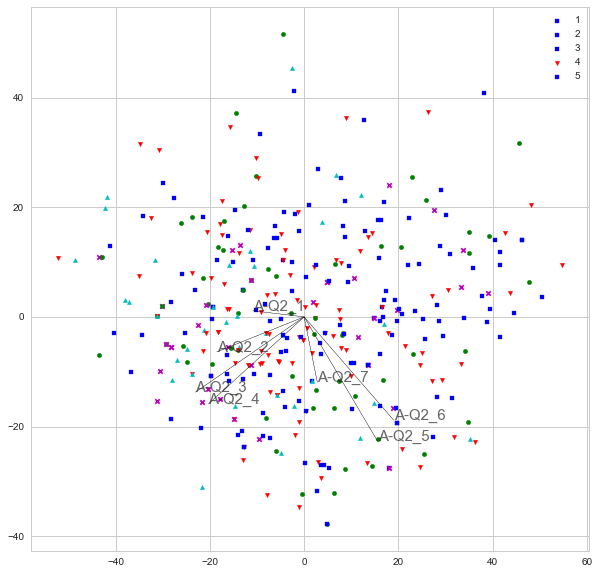

In [91]:
graf_biplot(Finished[Finished['D-Q4_neu']!=0][Liste_A_Q2],7,Finished[Finished['D-Q4_neu']!=0]['D-Q4_neu'])

n(1)= 287
n(2)= 91
n(3)= 6


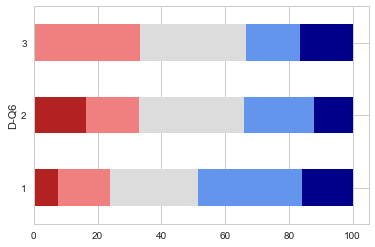

In [92]:
graf_diff_likert(Finished,'A-Q2_6','D-Q6');

In [93]:
df_test(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.718766,0.0580095,0.137,0.524765,0.15836
A-Q3_2,0.687633,0.108307,0.167948,0.379556,0.127954
A-Q3_3,0.0461003,0.48443,0.20516,0.63598,0.41581
A-Q3_4,0.511128,0.428897,0.0238946,0.840159,0.0159038
A-Q3_5,0.317178,0.00710896,0.050103,0.991811,0.27319
A-Q3_6,0.512935,0.00222531,8.92328e-08,0.00508136,0.286744
A-Q3_7,0.468818,0.000200322,2.81962e-10,0.00195816,0.251741
A-Q3_8,0.0824661,2.07128e-05,9.34152e-11,6.69927e-05,0.338006
A-Q3_9,0.0702715,0.000360269,0.0011927,0.172705,0.192495
A-Q3_28,0.599182,0.124317,0.15363,0.35537,0.440627


In [94]:
df_spearman(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.0257575,0.0178851,-0.0324192,0.0137284,0.0643286
A-Q3_2,-0.0356895,-0.0397815,-0.0842275,-0.0344582,0.0729916
A-Q3_3,-0.149657,0.0275669,-0.0994902,-0.00949256,0.00660861
A-Q3_4,0.0682142,-0.0478814,-0.0920461,-0.0152196,-0.0628978
A-Q3_5,-0.0490709,0.000757714,0.0164324,0.00964436,0.0222548
A-Q3_6,0.00673765,0.212981,0.294848,0.192775,0.0238553
A-Q3_7,0.0758419,0.252658,0.348607,0.205826,-0.00816626
A-Q3_8,-0.0339574,0.265996,0.338161,0.202955,0.029439
A-Q3_9,-0.110896,0.185917,0.172971,0.0728299,-0.0455453
A-Q3_28,0.0192339,0.0642016,0.104529,0.0911894,-0.0169906


Ergebnisse im Bereich "A-Q3":

Der Großteil der erkennbaren Unterschiede zwischen Gruppen in Bezug auf das Antwortverhalten bei einzelnen Items ist bei den Variablen Studienjahr, Niveau des aktuellen Deutschkurses und Alter zu finden. Die am stärksten beeinflussten Items sind 6, 7 und 8 (Analyse von Wortteilen, wobei sowohl grammatikalische als auch lexikalische Vorkenntnisse genutzt werden), diese korrelieren positiv mit den genannten Variablen, insbesondere dem Niveau. Weniger stark, aber ähnlich ist der Effekt bei Item 9 (orthographische Kenntnisse nutzen). Item 5 (Lautentsprechungen mit anderen germanischen Sprachen nutzen) wird vor allem von TN des vierten Studienjahres angegeben, allerdings auch stärker von TN des ersten Jahres als des zweiten und dritten. (Das könnte daran liegen, dass Studierende anderer Philologien (darunter Anglistik) Deutsch meist im ersten, zum Teil auch noch im zweiten Studienjahr belegen - und nur diese an der Befragung teilnahmen.) Item 10 (Satzstellung) scheint am stärksten von TN in Niveau A2 gewählt zu werden, allerdings auch verstärkt im vierten Studienjahr und in weiterführenden Studien, Item 11 und 12 (syntaktische und semantische Relationen) leicht zunehmend mit Niveau, am stärksten auf B2, ebenso verstärkt in weiterführenden Studien. Letzteres trifft auch auf Item 13 (systematische lexikalische Beziehungen) zu. Item 14 (Konnektoren etc.) wird vor allem auf den mittleren Niveaus angegeben, Item 16 mit leicht zunehmender Tendenz nach Niveau (in etwas in Korrelation mit Studienjahr und Alter).

Die Variable Studienrichtung scheint bei Item 3 (Vergleich mit anderen Sprachen), Item 24 (Kommunikationssituation etc.) und Item 29 (weiteren Kontext zur Kontrolle nutzen) zu unterschiedlichem Antwortverhalten zu führen. Item 3 wird verstärkt von Germanistikstudierenden, gefolgt von anderen Philologien und Translation, angegeben, Item 24 wird von Studierenden anderer Studienrichtungen weniger häufig genutzt, Item 29 von Studierenden anderer Philologien.

Die Unterschiede in Bezug auf die Variable Geschlecht stellen sich bei näherer Betrachtung als wenig aussagekräftig heraus. Weibliche TN geben Item 15 (Erkärungshilfen im Text nutzen), ebenso Item 4 (Klang) und 16 (logische Zusammenhänge). Bei Item 19 (Fachwissen) und 20 (Weltwissen) ist es umgekehrt (mehr Zuspruch unter männlichen TN).


Im Bereich "A-Q4" (kombinierte Strategiennutzung) konnten keine Unterschiede festgestellt werden.

n(1)= 146
n(2)= 60
n(3)= 103
n(4)= 34
n(5)= 35


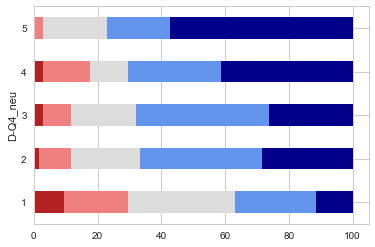

In [95]:
graf_diff_likert(Finished,'A-Q3_7','D-Q4_neu');

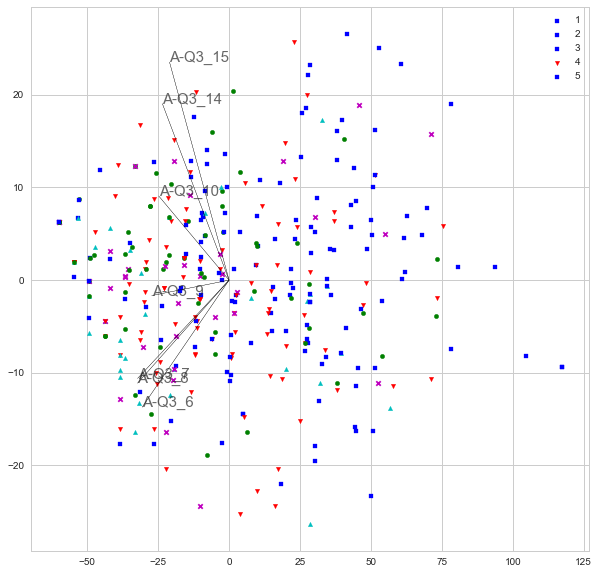

In [96]:
graf_biplot(Finished[Finished['D-Q4_neu']!=0][fakt['F1']],7,Finished[Finished['D-Q4_neu']!=0]['D-Q4_neu'])

In [97]:
df_test(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.289751,0.0284815,0.032553,0.013105,0.336042
C-Q1_2,0.710204,0.44379,0.0288777,0.548266,0.353475
C-Q1_3,0.420247,0.121296,0.0150643,0.704054,0.0544477
C-Q1_4,0.124659,0.299893,0.0181235,8.9333e-05,0.444205
C-Q1_5,0.298107,0.0371328,0.326933,0.0158317,0.409249
C-Q1_6,0.412963,0.813215,0.986074,0.025572,0.116397
C-Q1_7,0.371045,0.182882,0.651416,0.0193106,0.188986


In [98]:
df_spearman(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.0312548,0.0826082,0.133303,0.0645753,-0.046856
C-Q1_2,0.0144301,-0.0598871,-0.155006,0.0424787,0.0472148
C-Q1_3,-0.0344238,0.127986,0.169897,0.0515854,0.0821218
C-Q1_4,0.0529244,0.104396,0.15172,0.166927,0.0361898
C-Q1_5,-0.00453121,0.147396,0.0934733,0.126552,0.0505437
C-Q1_6,-0.0624782,0.0667258,0.0326192,0.166735,0.0789863
C-Q1_7,0.0363584,-0.0985123,-0.0702101,-0.146623,-0.0579939


Ergebnisse im Bereich "C-Q1":

Bis auf eine Ausnahme fallen die Ergebnisse der Unterschiedshypothesen- und Korrelationstests weniger deutlich als in anderen Bereichen der Befragung aus.

Es scheint ein Zusammenhang zwischen der Bedeutung, der Erschließungsstrategien bzw. deren Erwerb zugesprochen wird (Items 4, 5 und 6 bzw. Item 7 mit negativem Vorzeichen), und dem Alter der Befragten zu bestehen. (Je älter, desto bewusster.) 

Eine leicht positive Korrelation besteht zwischen Item 1 (wahrgenommene Strategienkompetenz), Item 3 (Einsatz der Strategien in der Freizeit) und dem Niveau des aktuellen Deutschenkurses, eine leicht negative zu Item 2 (Bedeutung der Strategien im aktuellen Deutschkurs).

n(1)= 146
n(2)= 60
n(3)= 103
n(4)= 34
n(5)= 35


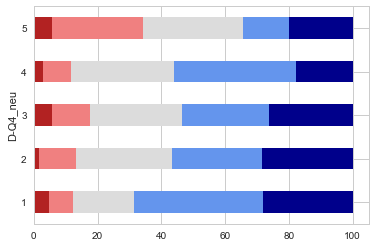

In [99]:
graf_diff_likert(Finished,'C-Q1_2','D-Q4_neu');

##### Sprachkenntnisse

In [100]:
df_test2(Finished,Liste_A_Q2)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q2_1,0.175402,0.190228,0.0963055,0.208085,0.43507,0.105034,0.0957262,0.413845,0.475264
A-Q2_2,0.241634,0.46089,0.242011,0.334106,0.440307,0.00732996,0.105179,0.10621,0.316994
A-Q2_3,0.261618,0.325804,0.18347,0.167178,0.280041,0.00249991,0.00509267,0.117962,0.34653
A-Q2_4,0.111564,0.459077,0.309011,0.348082,0.129806,0.000138317,0.0329131,0.15408,0.484624
A-Q2_5,0.336,0.393787,0.0091305,0.179259,0.0355658,0.269703,0.323969,0.219267,0.0782595
A-Q2_6,0.0925329,0.37136,0.00911673,0.185454,0.0291609,0.200478,0.138551,0.00705916,0.430327
A-Q2_7,0.283139,0.295197,0.268505,0.210965,0.258598,0.283978,0.0489764,0.454109,0.474152


Unterschiede im Antwortverhalten lassen sich in folgenden Bereichen feststellen:

* TN mit Kenntnis weiterer germanischer Sprachen: häufiger Nutzung weiterer Sprachkenntnisse, Kenntnisse des Deutschen und Kontext
* TN mit Kenntnis weiterer romanischer Sprachen: häufiger Nutzung der Kenntnisse des Deutschen und Kontext, außerdem etwas weniger Zuspruch bei Wörterbuchnutzung
* TN mit Französischkenntnissen, ähnlich auch bei Latein: mehr soziale Strategien 
* TN mit Kenntnis slawischer Sprachen: weniger soziale Strategien, vor allem Item 6 (Hilfe durch Kommilitonen) 


n(0)= 358
n(1)= 32


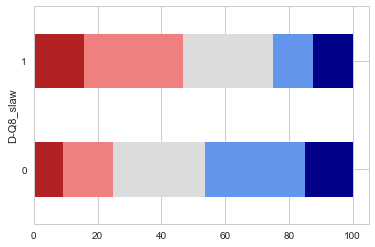

In [101]:
graf_diff_likert2(Finished,'A-Q2_6','D-Q8_slaw');

In [102]:
df_test2(Finished,Liste_A_Q3)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q3_1,0.00872596,0.247371,0.106896,0.272676,0.476217,0.0612518,0.00872431,0.436799,0.377797
A-Q3_2,0.363789,0.0599035,0.272408,0.253684,0.311026,0.0795338,0.349366,0.466178,0.105728
A-Q3_3,0.131539,0.225585,0.0412368,0.0887467,0.408421,0.00191444,0.185473,0.0389049,0.0630173
A-Q3_4,0.020044,0.342023,0.00992478,0.367274,0.357163,0.233246,0.406361,0.229507,0.116131
A-Q3_5,0.11881,0.154361,0.439207,0.122936,0.375043,0.0231618,0.0193208,0.187996,0.0239429
A-Q3_6,0.338064,0.491084,0.172421,0.231927,0.283662,0.0148944,0.243079,0.0706147,0.126849
A-Q3_7,0.472651,0.168468,0.348892,0.0708275,0.0496516,0.00732952,0.0839307,0.0317587,0.124092
A-Q3_8,0.160736,0.102709,0.468997,0.0124888,0.00973692,0.000547896,0.397231,0.251842,0.259938
A-Q3_9,0.00323042,0.0325399,0.392237,0.146233,0.109414,0.00087404,0.124746,0.0464295,0.377362
A-Q3_28,0.0581359,0.0989248,0.108149,0.102716,0.233834,0.0250183,0.138557,0.0149333,0.445073


Ergebnisse im Bereich "A-Q3":

* TN mit Spanisch als (einer der) Erstsprache(n): häufiger Nutzung der Erstsprache, auch andere Strategien wie Orthographie, Symbole... 
* Bilinguale TN: wenig signifikante Unterschiede, weniger Nutzung von Hyperlinks, andere Items etwas mehr
* TN mit Franz.: mehr Nutzung anderer Sprachkenntnisse und Klang
* TN mit Latein: Item 7 und 8 verstärkt (morphologisches Wissen und Kenntnis der Bedeutung von Suffixen etc.); ähnlich bei Altgr.: Item 8, auch 14
* TN mit germ. K.: bei vielen Items größerer Zuspruch, stärkste Unterschiede bei 7, 8 und 9
* TN mit rom. K.: stärkere Nutzung der Erstsprache, verstärkt auch einige andere Items, darunter Weltwissen, Strategienkombination
* TN mit slaw. K.: häufiger Item 15 (Erklärungshilfen) und 16 (logische Zusammehänge), auch einige weitere
* TN mit asiat. K.: häufiger Item 31 (weitere Strategien bei Problemen suchen), bei Item 5 extremeres Antwortverhalten (wenig "3")


In Bezug auf Muster in der Strategiennutzung (A-Q4) zeigt sich ein positiver Zusammenhang mit Altgriechischkenntnissen, ebenso Latein, in geringerem Maße auch germanischen und slawischen Sprachen.

n(0)= 353
n(1)= 37


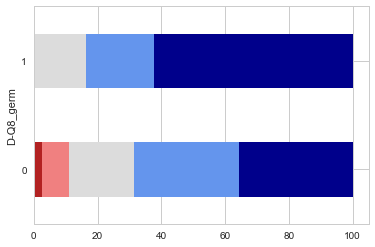

In [103]:
graf_diff_likert2(Finished,'A-Q3_9','D-Q8_germ');

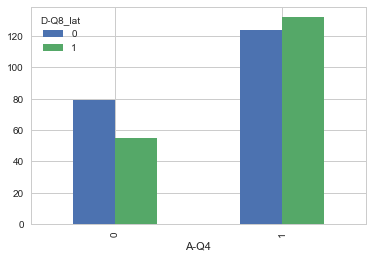

In [104]:
graf_diff2(Finished,'A-Q4','D-Q8_lat');

In [105]:
df_test2(Finished,Liste_C_Q1)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
C-Q1_1,0.368478,0.320908,0.16448,0.463221,0.143519,0.00655009,0.0453963,0.0411635,0.212051
C-Q1_2,0.0785706,0.246138,0.179813,0.107519,0.243505,0.225683,0.0140895,0.410978,0.116875
C-Q1_3,0.0412318,0.372839,0.275128,0.216334,0.408781,5.8185e-06,0.110563,0.000115082,0.00806101
C-Q1_4,0.153809,0.293681,0.191012,0.0497555,0.121394,0.108021,0.060169,0.243941,0.494557
C-Q1_5,0.388287,0.182565,0.439795,0.238779,0.254283,0.0155671,0.0106723,0.117119,0.381101
C-Q1_6,0.131295,0.215642,0.330492,0.260155,0.0266685,0.00152597,0.335054,0.465446,0.03308
C-Q1_7,0.396486,0.27346,0.109332,0.487654,0.493327,0.434874,0.314149,0.443166,0.319621


Erkenntnisse im Bereich C-Q1:

* TN mit germ. K.: stärkere Zustimmung zu Bedeutung von Erschließungsstrategien und deren Training, eigene Kompetenz und Nutzung in der Freizeit
* TN mit slaw., asiat. K.: häufigere Nutzung in der Freizeit (ev. auf Erschließung anderer Sprachen bezogen?)

Die weiteren Unterschiede können als kaum signifikant betrachtet werden.

n(0)= 353
n(1)= 37


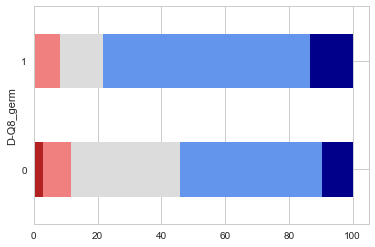

In [106]:
graf_diff_likert2(Finished,'C-Q1_1','D-Q8_germ');

##### Strategienerwerbskontexte

In [107]:
df_test3(Finished,Liste_A_Q2)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q2_1,0.49378,0.444053,0.283473,0.399399,0.0258077,0.358996,0.483507,0.173157,0.209704
A-Q2_2,0.374349,0.356219,0.140799,0.291892,0.0821503,0.158093,0.027317,0.257878,0.00280428
A-Q2_3,0.482022,0.29223,0.00793167,4.39746e-05,3.76462e-06,0.042728,0.180891,0.00523911,0.0202842
A-Q2_4,0.0935396,0.318228,0.276689,0.000150556,0.00275364,0.0501087,0.00204329,0.00476239,0.0319838
A-Q2_5,0.00517345,0.00500057,0.0467035,0.184772,0.383895,0.0343721,0.00608435,0.37432,0.203177
A-Q2_6,0.19595,0.000603458,0.0155172,0.00337626,0.237401,0.188267,0.075076,0.305911,0.00912113
A-Q2_7,0.28599,0.442332,0.05242,0.0481501,0.316062,0.0217097,0.0129721,0.238647,0.486091


In welchen Kontexten die TN (nach ihrer Wahrnehmung) Erschließungsstrategien erworben haben, scheint Einfluss auf die Strategiennutzung und -bewertung (siehe unten) zu haben.

Im Allgemeinen besteht der festgestellte Unterschied darin, dass TN, die den jeweiligen Kontext angegeben haben, mehr Zustimmung zu der jeweiligen Strategienkategorie zeigen.

Ausnahmen (geringere Zustimmung zur jeweiligen Kategorie):

E4 (früherer universitärer Deutschkurs), E9 (autonom) und Item 6 (Kommilitonen um Hilfe bitten)

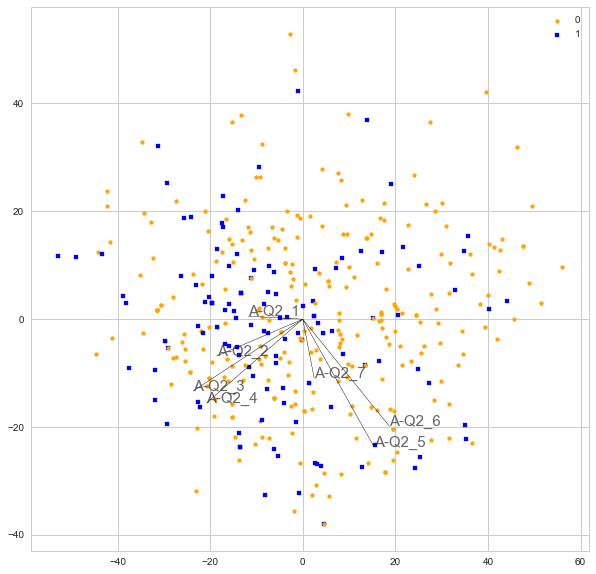

In [178]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['B-Q2_E4'])

n(0)= 271
n(1)= 119


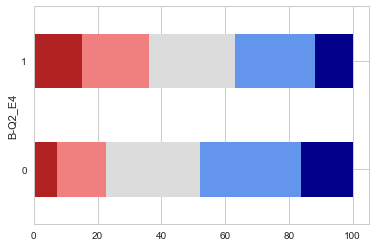

In [167]:
graf_diff_likert2(Finished,'A-Q2_6','B-Q2_E4');

In [108]:
df_test3(Finished,Liste_A_Q3)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q3_1,0.430694,0.0762605,0.0301392,0.166078,0.283826,0.211762,0.0646173,0.261398,0.181119
A-Q3_2,0.304775,0.00920999,0.0523262,0.0380489,0.33652,0.406696,0.384596,0.0940453,0.118636
A-Q3_3,0.493677,0.0922206,0.00296696,0.142066,0.32068,0.241283,0.238884,0.459496,0.0351946
A-Q3_4,0.470563,0.139599,0.210369,0.133151,0.315,0.159598,0.275518,0.0345711,0.427905
A-Q3_5,0.128154,0.381043,0.0195554,0.401571,0.0530219,0.318169,0.492868,0.152693,0.298488
A-Q3_6,0.00644985,0.306507,0.0412867,0.00128789,0.0013961,0.0902024,0.265012,0.00863803,0.0608667
A-Q3_7,0.189561,0.119728,0.0570996,2.3944e-05,2.07588e-05,0.207972,0.184271,0.0462629,0.0950379
A-Q3_8,0.0548808,0.0244408,0.368759,8.92455e-05,4.9796e-06,0.185143,0.23922,0.0511423,0.00178513
A-Q3_9,0.246445,0.414741,0.463682,0.000138747,0.000166631,0.0589254,0.032746,0.0283595,0.00134012
A-Q3_28,0.125461,0.156901,0.140691,0.013475,0.0272367,0.179904,0.0371542,0.00217762,0.130456


Auch im Bereich der Einzelstrategien besteht der festgestellte Unterschied meist darin, dass TN, die den jeweiligen Kontext angegeben haben, mehr Zustimmung zum jeweiligen Item (Einzelstrategien) zeigen. Die Erwerbskontexte E4 (früherer universitärer Deutschkurs) und E5 (andere LV im Rahmen des Studiums) scheinen den größten Einfluss auf den wahrgenommenen Strategieneinsatz zu haben, gefolgt von E8 (sozialer Kontext) und E9 (autonom).

Ausnahmen (geringere Zustimmung zur jeweiligen Strategie):
* E1 (Lengua y Literatura): Item 6 (Wortbildungsregeln des Deutschen)
* E2 (Englischunterricht): Item 8 (morphologische Wortanalyse)
* E4 (früherer universitärer Deutschkurs): Item 2 (Vergleich mit Englisch)

Bei E9 (autonom) und Item 3 gleichmäßigere Verteilung auf Antwortoptionen (1 bis 5).

Interessante Unterschiede in E5 (andere LV im Rahmen des Studiums): zeigt Einfluss auf viele Items, klarer Zusammenhang mit einigen Strategien wie Item 12 und 13 (lexikalische Beziehungen im Satz), 21 (visuelle Textgestalt)

Im Bereich A-Q4 (kombinierter Strategieneinsatz) zeigt sich, dass TN, die die Erwerbskontexte E5, E6 (Sprachschule) und E8 angegeben haben, häufiger Strategien aus verschiedenen Kategorien kombinieren. (Der entscheidende Faktor scheint der Vergleich mit anderen Sprachen zu sein, da hier im Allgemeinen weniger Zustimmung zu finden ist.) Vergleichsweise weniger ist dies der Fall bei den Kontexten E1, E9 und E7 (aktueller Deutschkurs).

n(0)= 251
n(1)= 139


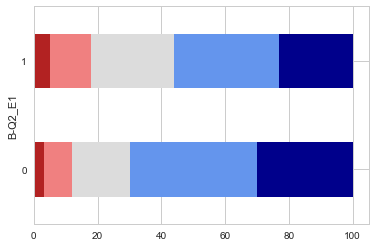

In [179]:
graf_diff_likert2(Finished,'A-Q3_6','B-Q2_E1');

n(0)= 254
n(1)= 136


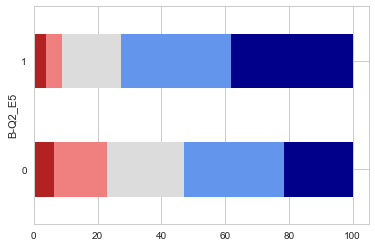

In [206]:
graf_diff_likert2(Finished,'A-Q3_8','B-Q2_E5');

n(0)= 254
n(1)= 136


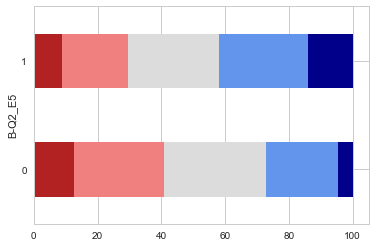

In [211]:
graf_diff_likert2(Finished,'A-Q3_12','B-Q2_E5'); # Item 13 sehr ähnlich

n(0)= 299
n(1)= 91


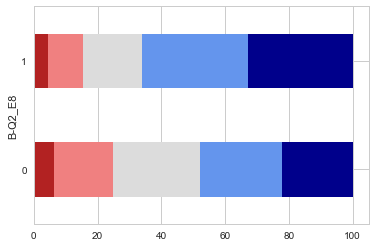

In [238]:
graf_diff_likert2(Finished,'A-Q3_27','B-Q2_E8');

n(0)= 171
n(1)= 217


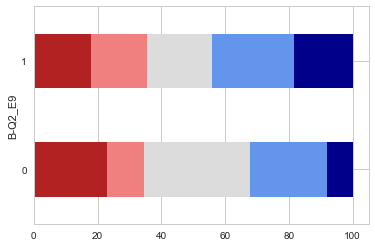

In [249]:
graf_diff_likert2(Finished,'A-Q3_3','B-Q2_E9');

In [109]:
get_good_str(Finished[Finished['B-Q2_E1']==1])

(91, 65.46762589928058)

In [110]:
get_good_str(Finished[Finished['B-Q2_E2']==1])

(156, 70.9090909090909)

In [111]:
get_good_str(Finished[Finished['B-Q2_E3']==1])

(122, 69.31818181818183)

In [112]:
get_good_str(Finished[Finished['B-Q2_E4']==1])

(84, 70.58823529411765)

In [113]:
get_good_str(Finished[Finished['B-Q2_E5']==1])

(104, 76.47058823529412)

In [114]:
get_good_str(Finished[Finished['B-Q2_E6']==1])

(115, 73.24840764331209)

In [115]:
get_good_str(Finished[Finished['B-Q2_E7']==1])

(159, 68.53448275862068)

In [116]:
get_good_str(Finished[Finished['B-Q2_E8']==1])

(67, 73.62637362637363)

In [117]:
get_good_str(Finished[Finished['B-Q2_E9']==1])

(147, 67.12328767123287)

In [118]:
df_test3(Finished,Liste_C_Q1)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
C-Q1_1,0.023853,0.193494,0.159266,0.338905,0.00615263,0.455685,0.156928,0.0183788,0.00453191
C-Q1_2,0.0320839,0.0259582,0.013764,0.144959,0.0463571,0.419601,0.00897872,0.403365,0.224211
C-Q1_3,0.0183371,0.0963517,0.212522,0.0485834,0.00585558,0.257579,0.0763913,0.0538626,0.0076986
C-Q1_4,0.346671,0.305555,0.432337,0.0059743,0.0259004,0.201647,0.00517378,0.0788012,0.0541259
C-Q1_5,0.393336,0.165803,0.270206,0.126279,0.000437044,0.293179,0.0272636,0.195059,0.0466985
C-Q1_6,0.218827,0.360078,0.275213,0.104851,2.55576e-05,0.240573,0.0287954,0.150345,0.492701
C-Q1_7,0.188723,0.232464,0.0431042,0.218171,0.164495,0.123763,0.00236505,0.0426596,0.365479


Zusammenhänge können vor allem zwischen Angabe der Erwerbskontexte E5 und E7 festgestellt werden. Im Allgemeinen besteht der Unterschied in höherer Zustimmung zum jeweiligen Item, abgesehen von Item 7, wo das Gegenteil der Fall ist.

Etwas unterschiedlich sind die Kontexte E1 bis E3:

E1: Item 1 und 3 etwas weniger Zuspruch
E1 bis E3: Item 2 etwas mehr Zuspruch
E3: Item 7 etwas mehr Zuspruch

n(0)= 158
n(1)= 232


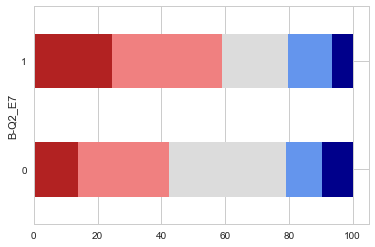

In [270]:
graf_diff_likert2(Finished,'C-Q1_7','B-Q2_E7');

n(0)= 254
n(1)= 136


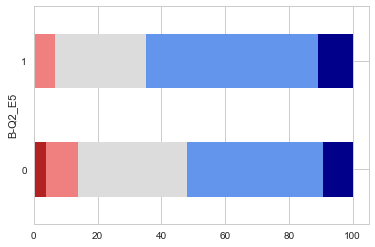

In [277]:
graf_diff_likert2(Finished,'C-Q1_1','B-Q2_E5');

##### Methoden des Strategienerwerbs in Unterrichtskontexten

In [119]:
df_test4(Finished,Liste_A_Q2)

,U1,U2,U3,U4,U5,U6
A-Q2_1,0.209211,0.0598179,0.0923377,0.300915,0.360079,0.291934
A-Q2_2,0.173046,0.343757,0.172517,0.0650371,0.0108366,0.0230903
A-Q2_3,0.150018,0.0369125,0.0441735,0.00274545,0.000631001,0.020431
A-Q2_4,0.258065,0.455679,0.0486804,0.0274783,0.325265,0.000538525
A-Q2_5,0.061453,0.163256,0.0138595,0.394778,0.0896321,0.356745
A-Q2_6,0.303697,0.0348541,0.0382399,0.312703,0.172759,0.499409
A-Q2_7,0.330794,0.0504621,0.0231831,0.481144,0.182686,0.192923


Die Methoden des Strategienerwerbs zeigen zum Teil Einfluss auf die angegebenen Strategienkategorien, diese werden höher bewertet. Am deutlichsten zeigt sich der Zusammenhang bei U4 (Strategien ausprobieren und vergleichen), U5 (Reflexion) und Item 3 (Kenntnisse des Deutschen nutzen) sowie U6 (unbewusst im Unterricht) und Item 4 (Kontext).

n(0)= 242
n(1)= 148


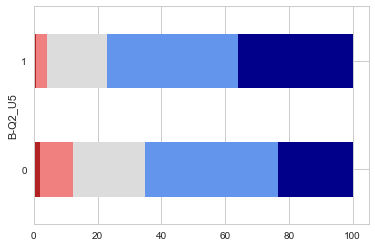

In [327]:
graf_diff_likert2(Finished,'A-Q2_3','B-Q2_U5');

In [120]:
df_test4(Finished,Liste_A_Q3)

,U1,U2,U3,U4,U5,U6
A-Q3_1,0.39716,0.283206,0.403982,0.302912,0.163727,0.00311441
A-Q3_2,0.431834,0.111725,0.0458044,0.27304,0.152965,0.00197753
A-Q3_3,0.263703,0.107811,0.12942,0.0313569,0.00172316,0.0430252
A-Q3_4,0.365705,0.254119,0.147452,0.0637012,0.269884,0.280231
A-Q3_5,0.302696,0.0263312,0.239125,0.0122395,0.401528,0.146346
A-Q3_6,0.455892,0.259122,0.455349,0.0951489,0.359714,0.0998038
A-Q3_7,0.484804,0.36052,0.270054,0.0377218,0.48454,0.0320985
A-Q3_8,0.174408,0.128437,0.49833,0.240016,0.44548,0.0179702
A-Q3_9,0.384175,0.220573,0.301581,0.30498,0.0481805,0.190711
A-Q3_28,0.150974,0.261216,0.026503,0.106271,0.495761,0.46135


Auch bei der Analyse der Einzelstrategien können Zusammenhänge zwischen Methoden des Strategienerwerbs und Items festgestellt werden, jeweils als positiver Einfluss (höherer Zuspruch). U4, U5 und U6 zeigen erneut die größten Unterschiede. Methode U1 (Erklärung der Strategien durch die Lehrkraft) scheint keinen signifikanten Einfluss auf die Angabe von Einzelstrategien zu haben.

Die signifikantesten Unterschiede scheinen jedoch im Bereich A-Q4 auf. Die Nennung bestimmter Methoden der Strategienvermittlung (nicht des unbewussten Ewerbs im Unterricht!) steht in Zusammenhang mit einem breiteren Strategieneinsatz. Die höchsten Werte finden wir bei TN, die U4 (Strategien ausprobieren und vergleichen) und U5 (Reflexion) angeben.

n(0)= 192
n(1)= 198


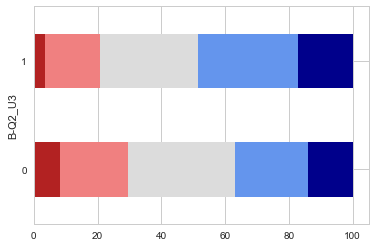

In [329]:
graf_diff_likert2(Finished,'A-Q3_24','B-Q2_U3');

n(0)= 240
n(1)= 148


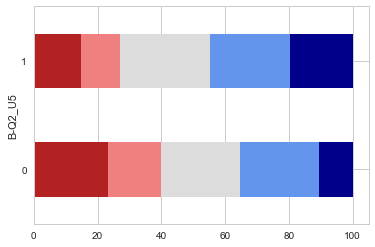

In [313]:
graf_diff_likert2(Finished,'A-Q3_3','B-Q2_U5');

n(0)= 127
n(1)= 263


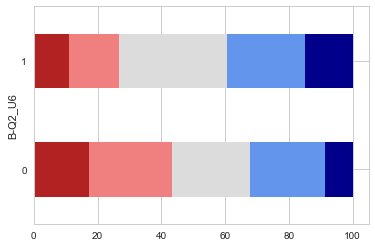

In [317]:
graf_diff_likert2(Finished,'A-Q3_1','B-Q2_U6');

n(0)= 127
n(1)= 263


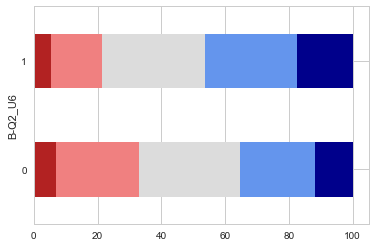

In [325]:
graf_diff_likert2(Finished,'A-Q3_24','B-Q2_U6');

In [121]:
get_good_str(Finished[Finished['B-Q2_U1']==1])

(143, 71.14427860696517)

In [122]:
get_good_str(Finished[Finished['B-Q2_U2']==1])

(173, 70.04048582995951)

In [123]:
get_good_str(Finished[Finished['B-Q2_U3']==1])

(142, 71.71717171717171)

In [124]:
get_good_str(Finished[Finished['B-Q2_U4']==1])

(88, 77.19298245614034)

In [125]:
get_good_str(Finished[Finished['B-Q2_U5']==1])

(113, 76.35135135135135)

In [126]:
get_good_str(Finished[Finished['B-Q2_U6']==1])

(177, 67.30038022813687)

In [127]:
df_test4(Finished,Liste_C_Q1)

,U1,U2,U3,U4,U5,U6
C-Q1_1,0.412408,0.28744,0.0388713,0.37098,0.127796,0.00770602
C-Q1_2,0.0537277,7.11644e-05,0.00137414,0.00800309,0.00347189,0.151402
C-Q1_3,0.108755,0.299947,0.126993,0.335831,0.288071,0.0078081
C-Q1_4,0.0508477,0.270783,0.112996,0.279649,0.00486872,0.0148164
C-Q1_5,0.0009061,0.026338,0.0244708,0.082721,0.0818027,0.00394622
C-Q1_6,0.00835608,0.00578504,0.0015506,0.481713,0.0442835,0.0862857
C-Q1_7,0.0489648,0.0182589,0.0112128,0.319702,0.0127889,0.178039


Auch im Bereich C-Q1 können einige Unterschiede in Bezug auf Methoden des Strategienwerbs festgestellt werden. 

Ein positiver Zusammenhang scheint zwischen Vermittlungsmethoden (außer U1) und der Bedeutung der Strategien im aktuellen Deutschkurs (Item 2) zu bestehen. U1, U2 und U3 stehen in Verbindung mit höherem Zuspruch zu Item 5 (besseres Textverständnis) und 6 (Strategien sollten erklärt und geübt werden) und niedrigerem zu Item 7 (kein Bedarf zu lernen). 

Geringfügig weniger Zuspruch bei Item 1 (erfolgreicher Strategieneinsatz) zeigt U3 (eventuell, weil diese Methode eher im Anfängerunterricht eingesetzt wird?). 

U6 steht in Zusammenhang mit höherer Selbsteinschätzung bei Item 1, interessant ist hier auch der Vergleich mit den nicht signifikaten Ergebnissen anderer Methoden wie U5. U6 zeigt auch höherere Zustimmung bei Item 3, 4 und 5.

n(0)= 192
n(1)= 198


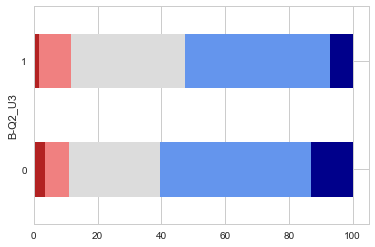

In [339]:
graf_diff_likert2(Finished,'C-Q1_1','B-Q2_U3');

n(0)= 127
n(1)= 263


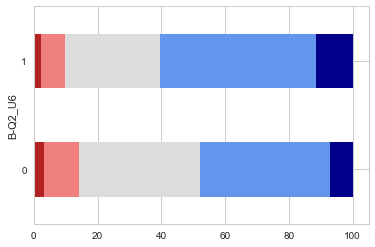

In [347]:
graf_diff_likert2(Finished,'C-Q1_1','B-Q2_U6');

n(0)= 242
n(1)= 148


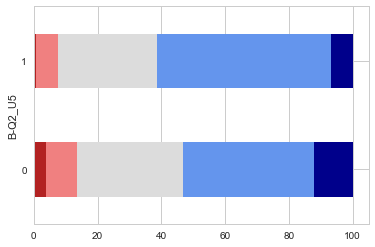

In [346]:
graf_diff_likert2(Finished,'C-Q1_1','B-Q2_U5');

n(0)= 325
n(1)= 65


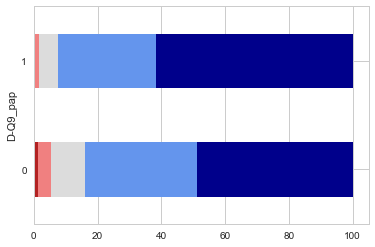

In [360]:
graf_diff_likert2(Finished,'A-Q2_7','D-Q9_pap');

##### Erhebungssituation

In [130]:
df_test5(Finished,Liste_A_Q2)

,Erh_sit,Erh_pap,Sal,Sev,Vigo,Gran,Sant,Madrid,pilot
A-Q2_1,0.000816719,0.000887041,0.0347377,0.00345538,0.17905,0.144851,0.0275171,0.41368,0.324581
A-Q2_2,0.0256985,0.175718,0.309226,0.297906,0.217617,0.309442,0.445325,0.156993,0.472122
A-Q2_3,0.088275,0.0762864,0.255511,0.000924443,0.00833302,0.00145292,0.0146186,0.18704,0.0079671
A-Q2_4,0.0198049,0.010209,0.0863551,0.000496374,0.00962004,2.52283e-06,0.0588786,0.486654,0.0229425
A-Q2_5,0.41386,0.279055,0.378542,0.343435,0.131253,0.216758,0.101491,0.453338,0.154909
A-Q2_6,0.460514,0.214502,0.0423653,0.207288,0.102941,0.000107228,0.406514,0.0490625,0.158727
A-Q2_7,0.435448,0.0175793,0.012488,0.0731624,0.0573452,0.0408886,0.134172,0.387512,0.0742117


In [131]:
df_test5(Finished,Liste_A_Q3)

,Erh_sit,Erh_pap,Sal,Sev,Vigo,Gran,Sant,Madrid,pilot
A-Q3_1,0.12586,0.103353,0.192107,0.203652,0.145319,0.235127,0.138971,0.224403,0.199015
A-Q3_2,0.121439,0.113267,0.116398,0.429948,0.0503067,0.357954,0.362542,0.0183935,0.450572
A-Q3_3,0.251325,0.31269,0.243596,0.485032,0.124886,0.0524075,0.188931,0.0255907,0.180506
A-Q3_4,0.0274144,0.0203515,0.00339151,0.29337,0.0646604,0.173642,0.149082,0.0719802,0.209743
A-Q3_5,0.34708,0.241875,0.00891158,0.0348891,0.406308,0.434385,0.212784,0.116696,0.0449219
A-Q3_6,0.172319,0.00185312,0.00783744,0.00782035,0.000285832,0.12372,0.40881,0.447574,0.000415862
A-Q3_7,0.339017,0.0177629,0.193476,0.00533204,8.23275e-06,0.0359972,0.0719326,0.294362,1.09681e-05
A-Q3_8,0.218741,0.001139,0.182167,0.00035361,5.84137e-09,0.0407317,0.0871308,0.225125,0.000104937
A-Q3_9,0.494644,0.00561752,0.173145,0.000212599,2.0455e-06,0.4911,0.134975,0.1732,0.000873537
A-Q3_28,0.0760513,0.411663,0.112463,0.0431274,0.0373984,0.0710482,0.143885,0.46803,0.0417553


In [132]:
df_test5(Finished,Liste_C_Q1)

,Erh_sit,Erh_pap,Sal,Sev,Vigo,Gran,Sant,Madrid,pilot
C-Q1_1,0.351113,0.428761,0.0139562,0.0386293,0.093078,0.000676253,0.0135616,0.258446,0.0267237
C-Q1_2,0.303934,0.00744457,0.0411068,0.169136,0.0401766,0.373529,0.301403,0.354017,0.214131
C-Q1_3,0.218824,0.0999026,0.015507,0.00389467,0.0198388,0.0134498,0.212621,0.180314,0.00317324
C-Q1_4,0.045695,0.393703,0.446525,0.0419543,0.0840084,0.000847625,0.0916384,0.317937,0.264954
C-Q1_5,0.0248717,0.185023,0.0907471,0.252174,0.038866,0.0356829,0.0112583,0.253457,0.128427
C-Q1_6,0.428284,0.0583302,0.159215,0.0438809,0.232315,0.194544,0.329528,0.157239,0.476579
C-Q1_7,0.0573296,0.218658,0.469647,0.0730622,0.302105,0.00135493,0.0370111,0.324258,0.327756


In [367]:
df_test5(Daten[Daten['Finished']==1],Liste_D)

,Erh_sit,Erh_pap,Sal,Sev,Vigo,Gran,Sant,Madrid,pilot
D-Q2a_neu,0.216403,0.264537,0.00630942,0.144396,0.274385,0.132621,0.269932,0.00415842,0.00124147
D-Q2b_neu,0.00168247,0.0203302,0.00105402,0.00231796,1.03345e-07,0.361456,1.49526e-05,0.00011875,8.05877e-10
D-Q4_neu,0.440451,1.39087e-08,9.51421e-05,5.59077e-08,2.15464e-13,8.31692e-09,0.00148972,0.387344,2.42923e-09
D-Q5_neu,0.351797,0.0086583,0.00832971,0.13183,1.00612e-07,5.29998e-06,0.00284804,0.0197521,0.00690711
D-Q6,0.389601,0.135073,0.358932,0.1238,0.471244,0.498502,0.404478,0.486454,0.416359


Bei einigen Items kann ein Einfluss der Erhebungssituation (während oder außerhalb des Unterrichts) vermutet werden. Wo signifikante Unterschiede bestehen, zeigt sich ein differenzierteres Antwortverhalten (insbesondere mehr niedrige Werte) im Fall der Beantwortung während der Unterrichtszeit.  

Eine weitere besondere Erhebungssituation stellt die Durchführung der Befragung mittels der Papierversion des Fragebogens dar. Auch hier können einige Unterschiede festgestellt werden. Allerdings ist zu beachten, dass die größte Gruppe von Studierenden, die mittels Papierfragebogen befragt wurde, von der Universität Sevilla stammt (54 Personen). Die übrigen TN dieser Gruppe sind nur 11 Personen aus Vitoria/País Vasco, Madrid und Salamanca. Die Unterschiede können also auch durch die Universität bedingt sein. Ein Einfluss der Verwendung des Papierfragebogens auf das Antwortverhalten kann daher nicht mit Sicherheit festgestellt werden. 

Die Analyse zeigt, dass ein Zusammenhang zwischen bestimmten Items und der Zugehörigkeit der Befragten zu unterschiedlichen Universitäten vorliegt. Allerdings sind mit der Universitätszugehörigkeit auch andere Faktoren wie Studienrichtung und Niveau des besuchten Deutschkurses sowie die Lehrkraft (nicht als Faktor erhoben, aber in der Fachliteratur angenommen) verbunden, sodass keine aussagekräftigen Schlüsse gezogen werden können. 

Weiters wurde analysiert, ob sich das Antwortverhalten der TN an der Pilotstudie und der Hauptstudie an der Universität Salamanca unterscheidet. Tatsächlich gibt es Hinweise auf unterschiedliches Antwortverhalten. Dieses kann jedoch durch andere Variablen, die ebenfalls beide Stichproben unterscheiden, zustandegekommen sein. Als zusätzlicher Test wurden die zuvor dargestellten Analysen auch unter Ausschluss der Teilnehmer der Pilotstudie durchgeführt. Die Ergebnisse unterscheiden sich nicht wesentlich, zum Teil wären weniger Unterschiede zwischen Gruppen (z.B. Studienrichtungen) erkenntlich. Dies lässt vermuten, dass die unterschiedliche Zusammensetzung der Stichprobe mehr Einfluss auf das Antwortverhalten hat als die Verwendung eines geringfügig anders gestalteten Fragebogens. (Die sprachlich abgeänderten Items 12 und 14 zeigen kein verändertes Antwortverhalten.)